Per-layer style dims: [[512, 512], [512, 512, 512], [512, 512, 512], [512, 512, 512], [512, 512, 512], [512, 256, 256], [256, 128, 128], [128, 64, 64]]
Style dim: 8960
Images generated from ws:


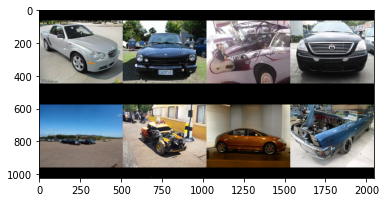

Size of styles tensor: torch.Size([8, 8960])
Images generated from styles:


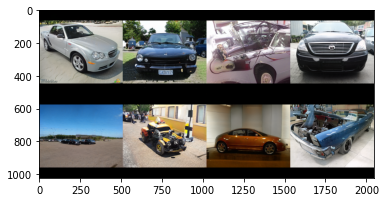

Mean style image:


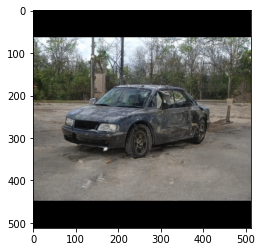

In [2]:
import legacy
import dnnlib
import torch
import matplotlib.pyplot as plt
import einops

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-car-config-f.pkl"
device = "cuda"
batch_size = 8

with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)["G_ema"]
    G = G.eval().requires_grad_(False).to(device)
    
# These are the per-layer dims of the styles.
print("Per-layer style dims:", G.synthesis.style_dims)

# And the total dim (sum of above).
print("Style dim:", G.synthesis.style_dim)

# Sanity check that ws produce same images.
z = torch.randn(batch_size, G.z_dim, device=device)
ws = G.mapping(z, c=None)
images = G.synthesis(ws)
images = einops.rearrange(images, "(nh nw) c h w -> (nh h) (nw w) c", nh=2, nw=batch_size//2)
images = (images * 127.5 + 128).clamp(0, 255).type(torch.uint8)
images = images.cpu().numpy()
print("Images generated from ws:")
plt.imshow(images)
plt.show()

# Now generate images from styles.
styles = G.synthesis.ws_to_styles(ws)
print("Size of styles tensor:", styles.size())
images = G.synthesis.styles_to_images(styles)
images = einops.rearrange(images, "(nh nw) c h w -> (nh h) (nw w) c", nh=2, nw=batch_size//2)
images = (images * 127.5 + 128).clamp(0, 255).type(torch.uint8)
images = images.cpu().numpy()
print("Images generated from styles:")
plt.imshow(images)
plt.show()

# Mean style image.
z = torch.randn(10000, G.z_dim, device=device)
ws = G.mapping(z, c=None)
styles = G.synthesis.ws_to_styles(ws)
mean_style = styles.mean(dim=0, keepdim=True)
images = G.synthesis.styles_to_images(mean_style)
images = einops.rearrange(images, "1 c h w -> h w c")
images = (images * 127.5 + 128).clamp(0, 255).type(torch.uint8)
images = images.cpu().numpy()
print("Mean style image:")
plt.imshow(images)
plt.show()
